# **Introduction**

This notebook is for implementing a Monte-Carlo reinforcement learning method on the Frozen Lake environment offered through the Gymnasium environment. Gymnasium is an open source Python library for developing and comparing reinforcement learning algorithms, through the use of a standardized API. There are four key functions to Gymnasium, namely: ```make()```, ```Env.reset()```, ```Env.step()```, and ```Env.render()```.

As per its [introductory documentation](https://gymnasium.farama.org/introduction/basic_usage/), the core of Gymnasium lies in the high-level Python class ```Env```, which approximately represents a Markov Decision Process (MDP) from reinforcement learning theory. This class allows users of Gymnasium to start new episodes, take actions, and visualize the agent's current state. 

# **Import Packages**

This section imports the necessary packages.

In [176]:
# import these:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# **Environment Setup**

This section sets up the environment and defines the relevant functions needed for this implementation. 

In [ ]:
# MC-Agent Class:
class GLIE_MC_Agent:
        ####################### INITIALIZATION #######################
        # constructor:
        def __init__(self, env: gym.Env, gamma: float, es : bool, rs: bool):
                """
                this is the constructor for the agent. this agent is a monte-carlo agent, meaning that it averages the returns
                for each Q(s,a) at the end of the episode

                env:    a gymnasium environment
                gamma:  a float value indicating the discounting factor
                es:     a boolean value indicating whether to use exploring starts or not
                rs:     a boolean value indicating whether to use custom rewards or not
                                if true:
                                        goal_value:     +10.0
                                        hole_value:     -1.0
                                else:
                                        goal_value:     +1.0
                                        hole_value:     0.0
                Q:      the estimate of the action-value function q, initialized as zeros over all states and actions
                
                """
                # object parameters:
                self.env = env
                self.gamma = gamma
                self.es = es
                self.rs = rs

                # reward shaping:
                if self.rs:
                        self.goal_value = 10.0
                        self.hole_value = -1.0
                else:
                        self.goal_value = 1.0
                        self.hole_value = 0.0

                # get the number of states, number of actions:
                nS, nA = env.observation_space.n, env.action_space.n

                # get the terminal spaces of the current map:
                desc = env.unwrapped.desc.astype('U1')
                chars = desc.flatten()
                self.terminal_states = [i for i, c in enumerate(chars) if c in ('H','G')]

                # tabular Q-values, and counter N(s,a):
                self.Q = np.zeros((nS, nA))
                self.visits = np.zeros((nS, nA), dtype = int)         # how many times I have been to a state, and taken an action         

                # return to the user the metrics about the environment:
                print(f"Action Space is: {env.action_space}")
                print(f"Observation Space is: {env.observation_space}\n")
        
        ####################### TRAINING #######################
        # function to perform ε-greedy probability assignment:
        def get_action_probs(self, Q):
                """ 
                this function does the ε-greedy probability assignment for the actions available in a given state

                Q:         a np.ndarray corresponding to the action-values of the actions available in a given state
                returns:   probability of selecting each action
                
                """
                # get the number of available actions:
                m = len(Q)

                # assign each action a base probability of ε/m
                p = np.ones(m)*(self.epsilon/m)

                # find the index of the best Q value
                best = np.argmax(Q)

                # give that one more probability by an amount equal to (1 - ε):
                p[best] += 1.0 - self.epsilon

                # this way the "best" action has a probability of ε/m + (1-ε), meaning it will be chosen more often
                # whereas the others have a probability of ε/m, so there is a probability that exploratory actions will be selected

                # return the probability of selecting each action:
                return p
        
        # ε-greedy policy function:
        def policy(self, state):
                """ 
                this is the ε-greedy policy itself, where it chooses an action based on the ε-greedy probabilities of each action

                state:   an int representing the current state
                returns: a randomly selected action

                """
                probs = self.get_action_probs(self.Q[state])    # for a given state, or row in Q
                return np.random.choice(len(probs), p = probs)  # pick an action from the probabilities of each action
        
        # episode generation function:
        def generate_episode(self):
                """ 
                this function is used to generate and run through episodes

                returns: a list of (obs, a, r) tuples

                """
                episode = []    # empty list for returns

                # exploring starts:
                if self.es:
                        non_terminals = [s for s in range(self.env.observation_space.n) if s not in self.terminal_states]
                        starting_state = np.random.choice(non_terminals)

                        # force env into starting state:
                        _, _ = self.env.reset()
                        self.env.unwrapped.s = starting_state 
                        obs = starting_state
                else:
                        obs, _ = self.env.reset()

                # flag for when to stop episode
                done = False

                while not done:
                        a = self.policy(obs)    # select an action based on the current state

                        next_obs, r, term, trunc, _ = self.env.step(a)    # take the action

                        # custom reward shaping:
                        if self.rs:
                                if term and r == 0:
                                        r = self.hole_value  # fell in hole
                                elif term and r == 1:
                                        r = self.goal_value  # reached goal

                        episode.append((obs, a, r))     # trajectories are given by {S_1, A_1, R_2, ... , S_T} 
                        obs = next_obs          # advance the state
                        done = term or trunc    # set done to True if term (terminal state) or trunc (environment cut episode short)

                # return episode information for GPI
                return episode
        
        def update_Q(self, episode):
                """ 
                this function updates the Q estimation using incremental every-visit MC at the end of an episode

                episode: the (s, a, r) list

                """
                g = 0   # initial return value
                for (s, a, r) in reversed(episode):
                        g = r + self.gamma * g  # get the return for that state
                        self.visits[s, a] += 1  # increment visits
                        n = self.visits[s, a]   # visit counter is used in the update rule

                        # update Q(s, a) based on update rule:
                        self.Q[s, a] += (g - self.Q[s, a]) / n
        
        # actual policy iteration:
        def GPI(self, num_episodes):
                """ 
                this function performs the generalized policy iteration, using GLIE evaluation and ε-greedy policy improvement

                num_episode: number of episodes to play out
                returns:     the updated Q values
                
                """
                for k in tqdm(range(num_episodes)):
                        # GLIE uses a decaying ε schedule:
                        self.epsilon = 1.0 / (0.005*k + 1)

                        # 1) play out an entire episode:
                        episode = self.generate_episode()

                        # 2) perform incremental, every-visit MC after the episode to approximate Q(s,a):
                        self.update_Q(episode)

                return self.Q
        
        ####################### EVALUATION #######################
        # average return per episode:
        def average_return(self, agent, num_episodes):
                """ 
                this function computes the average return per episode for a given amount of episodes

                agent:          the agent that has been trained
                num_episode:    number of episodes to play out
                returns:        the average return per episode
                
                """
                # initialize the total return received over the evaluation:
                total_return = 0

                # for every episode:
                for _ in range(num_episodes):
                        obs, _ = agent.env.reset()      # must reset before an episode
                        done = False                    # flag is set to False initially
                        episode_return = 0              # reset return for the episode

                        # while False:
                        while not done:
                                a = np.argmax(agent.Q[obs])                     # pick best action from policy
                                obs, r, term, trunc, _ = agent.env.step(a)      # step that action
                                episode_return += r     # increment the episode return by that return
                                done = term or trunc    # set to True if term or trunc
                        
                        total_return += episode_return  # increment total return by episode return
                
                return total_return / num_episodes      # average return accross all episodes
        
        # success rate:
        def success_rate(self, agent, num_episodes):
                """ 
                this function computes the success rate for a given amount of episodes

                agent:          the agent that has been trained
                num_episode:    number of episodes to play out
                returns:        the success rate for that stretch of episodes
                
                """
                # initialize number of successes:
                success = 0

                # for every episode:
                for _ in range(num_episodes):
                        obs, _ = agent.env.reset()      # must reset before an episode
                        done = False                    # flag is set to False initially

                        # while False:
                        while not done:
                                a = np.argmax(agent.Q[obs])                     # pick best action from policy
                                obs, r, term, trunc, _ = agent.env.step(a)      # step that action
                                done = term or trunc    # set to True if term or trunc

                        # if at the goal pose
                        if r == self.goal_value:
                                success += 1    # increment the success counter

                return (success / num_episodes) * 100   # return success rate


# **Using the Environment**

This section utilizes the above object-oriented implementation of RL to create an environment and train an agent.

In [ ]:
# create training environment:
env = gym.make("FrozenLake-v1", is_slippery = True)

# instantiate the agent:
agent = GLIE_MC_Agent(env = env, gamma = 0.99, es = False, rs = False)
num_episodes = 1000000

# learn value functions using MC:
q = agent.GPI(num_episodes = num_episodes).round(3)

Action Space is: Discrete(4)
Observation Space is: Discrete(16)



100%|██████████| 1000000/1000000 [15:28<00:00, 1076.64it/s]


# **Benchmark the Learned Policy**

This section uses the evaluation functions defined within the class to check how the learned policy fares over a set of episodes.

In [179]:
# set num_episodes to desired testing length:
num_episodes = 1000

# evaluate:
avg_return = agent.average_return(agent, num_episodes)
success_rate = agent.success_rate(agent, num_episodes)

# display to the user:
print(f"The average return per episode is: {avg_return}")
print(f"The success rate is: {success_rate}%")

The average return per episode is: 0.723
The success rate is: 73.5%


# **Visualize the Learned Policy**

This section visualizes the final policy that was learned and overlays a heatmap of the action-value function $Q(s,a)$.

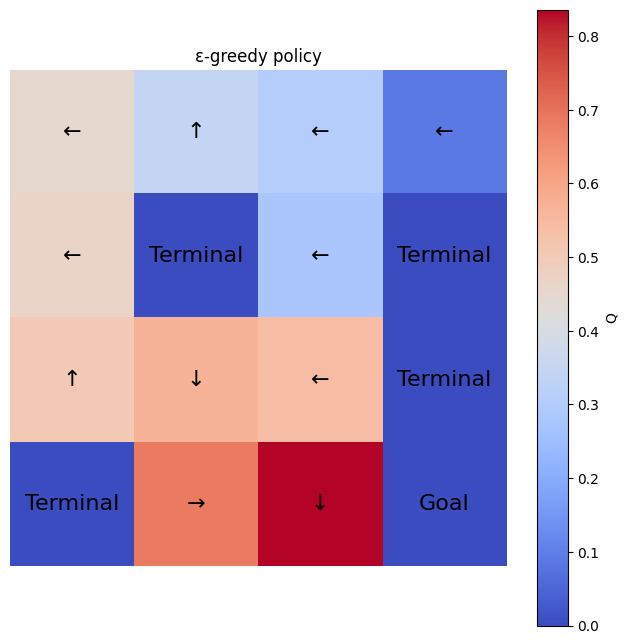

In [180]:
# define mapping of actions to directions:
action_map = {0: '←', 1: '↓', 2: '→', 3: '↑', 4: 'Terminal', 5 : 'Goal'}
size = int(np.sqrt(agent.env.observation_space.n))
grid = np.zeros(agent.env.observation_space.n, dtype = object)

# for every state:
for s in range(agent.env.observation_space.n):
    if s in agent.terminal_states:
        if s == 15:
            action = 5
        else:
            action = 4
    else:
        action = np.argmax(q[s, :])

    grid[s] = action_map[action]

# reshape to look like map:
grid = grid.reshape(size, size)

# plot stuff:
fig, ax = plt.subplots(figsize = (2*size, 2*size))

# heatmap stuff:
heatmap_value = np.max(q, axis = 1).reshape((4,4))
heatmap = ax.imshow(heatmap_value, cmap = 'coolwarm', interpolation = 'nearest')

# overlay text:
for i in range(size):
    for j in range(size):
        text = grid[i, j]
        ax.text(j, i, text, ha = 'center', va = 'center', color = 'black', fontsize = 16)

# formatting:
fig.colorbar(heatmap, ax = ax, label = 'Q')
ax.set_title('ε-greedy policy')
ax.axis('off')

plt.show()